<a href="https://colab.research.google.com/github/EvenSol/NeqSim-Colab/blob/master/notebooks/process/RL_Process_Control.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reinforcement Learning for Process Control in NeqSim

This notebook demonstrates how to use Deep Reinforcement Learning (DQN) to control a separation process.
The RL agent learns to manipulate valve openings to maintain target liquid level and pressure setpoints.

## Overview
- **Environment**: Oil-gas separator with inlet valve control
- **Agent**: Deep Q-Network (DQN) with experience replay
- **Objective**: Maintain separator liquid level at setpoint while managing pressure
- **Actions**: Adjust inlet valve opening (increase, decrease, hold)
- **State**: Liquid level, pressure, level error, valve opening


Same case as defined here

https://colab.research.google.com/github/EvenSol/NeqSim-Colab/blob/master/notebooks/process/dynsep.ipynb

In [ ]:
%%capture
! apt update -q
! apt-get install -q openjdk-25-jdk-headless -q
!pip install neqsim -q

## 1. Import Required Libraries

In [ ]:
# NeqSim imports
from neqsim import jneqsim as ns
from neqsim.thermo import fluid

# Standard libraries
import numpy as np
import matplotlib.pyplot as plt
import time
from collections import deque
import random

# Deep Learning - TensorFlow/Keras
try:
    import tensorflow as tf
    from tensorflow import keras
    from tensorflow.keras import layers
    print(f"TensorFlow version: {tf.__version__}")
except ImportError:
    print("TensorFlow not installed. Install with: pip install tensorflow")
    raise

TensorFlow version: 2.19.0


## 2. Define Process Environment

Create a custom environment that wraps the NeqSim process simulation.

In [ ]:
class SeparatorEnvironment:
    """Custom environment for separator process control using NeqSim.

    Allows dynamic setpoint changes for:
    - Feed flow rate
    - Separator pressure
    - Liquid level

    The RL agent controls three valves:
    - Feed inlet valve
    - Gas outlet valve
    - Liquid outlet valve
    """

    def __init__(self, timeStep=50, levelSetpoint=0.3, pressureSetpoint=5.0, flowRateSetpoint=150.0):
        self.timeStep = timeStep
        self.levelSetpoint = levelSetpoint
        self.pressureSetpoint = pressureSetpoint
        self.flowRateSetpoint = flowRateSetpoint

        # Action space: 9 discrete actions for 3 valves (each can decrease/hold/increase)
        # Action encoding: 0-2 (feed valve), 3-5 (gas valve), 6-8 (liquid valve)
        self.action_space_n = 9
        self.valve_step = 2.0  # percentage change per action

        # State space: [level, pressure, flow_rate, level_error, pressure_error,
        #                feed_valve, gas_valve, liquid_valve]
        self.state_space_n = 8

        # Process limits
        self.min_valve_opening = 1.0
        self.max_valve_opening = 99.0

        self.process = None
        self.current_step = 0
        self.max_steps = 200

    def set_level_setpoint(self, setpoint):
        """Dynamically change liquid level setpoint during operation."""
        self.levelSetpoint = np.clip(setpoint, 0.1, 0.9)

    def set_pressure_setpoint(self, setpoint):
        """Dynamically change pressure setpoint during operation."""
        self.pressureSetpoint = np.clip(setpoint, 1.0, 10.0)

    def set_flow_rate(self, flow_rate):
        """Dynamically change feed flow rate during operation."""
        self.flowRateSetpoint = np.clip(flow_rate, 50.0, 300.0)
        if self.process is not None:
            self.well_stream.setFlowRate(self.flowRateSetpoint, "kg/hr")

    def create_process(self):
        """Initialize the NeqSim process simulation."""
        # Process parameters
        sepLength = 4.0
        sepDiameter = 1.0
        sepLiqLevel = 0.2
        inletValveOpening = 50.0
        inletValvePressure = 5.0
        gasValveOpening = 50.0
        gasValvePressure = 2.0
        liquidValveOpening = 50.0
        liquidValvePressure = 2.0

        # Setup fluid composition
        wellfluid = fluid("pr")
        wellfluid.addComponent("CO2", 1.5870)
        wellfluid.addComponent("methane", 52.51)
        wellfluid.addComponent("ethane", 6.24)
        wellfluid.addComponent("propane", 4.23)
        wellfluid.addComponent("i-butane", 0.855)
        wellfluid.addComponent("n-butane", 2.213)
        wellfluid.addComponent("i-pentane", 1.124)
        wellfluid.addComponent("n-pentane", 1.271)
        wellfluid.addComponent("n-hexane", 2.289)
        wellfluid.addTBPfraction("C7+_cut1", 0.8501, 108.47 / 1000.0, 0.7411)
        wellfluid.addTBPfraction("C7+_cut2", 1.2802, 120.4 / 1000.0, 0.755)
        wellfluid.addTBPfraction("C7+_cut3", 1.6603, 133.64 / 1000.0, 0.7695)
        wellfluid.addTBPfraction("C7+_cut4", 6.5311, 164.70 / 1000.0, 0.799)
        wellfluid.addTBPfraction("C7+_cut5", 6.3311, 215.94 / 1000.0, 0.8387)
        wellfluid.addTBPfraction("C7+_cut6", 4.9618, 273.34 / 1000.0, 0.8754)
        wellfluid.addTBPfraction("C7+_cut7", 2.9105, 334.92 / 1000.0, 0.90731)
        wellfluid.addTBPfraction("C7+_cut8", 3.0505, 412.79 / 1000.0, 0.9575)
        wellfluid.setPressure(10)
        wellfluid.setTemperature(300)
        wellfluid.setMixingRule("classic")

        # Build process flowsheet
        wellStream = ns.process.equipment.stream.Stream("well stream", wellfluid)
        wellStream.setFlowRate(self.flowRateSetpoint, "kg/hr")
        self.well_stream = wellStream

        lcv00 = ns.process.equipment.valve.ThrottlingValve("LCV-00", wellStream)
        lcv00.setPercentValveOpening(inletValveOpening)
        lcv00.setOutletPressure(inletValvePressure)
        lcv00.setCalculateSteadyState(False)
        lcv00.setMinimumValveOpening(0.01)

        v001 = ns.process.equipment.separator.Separator("V-001", lcv00.getOutletStream())
        v001.setCalculateSteadyState(False)
        v001.setSeparatorLength(sepLength)
        v001.setInternalDiameter(sepDiameter)
        v001.setLiquidLevel(sepLiqLevel)

        lcv001 = ns.process.equipment.valve.ThrottlingValve("LCV-001", v001.getLiquidOutStream())
        lcv001.setPercentValveOpening(liquidValveOpening)
        lcv001.setOutletPressure(liquidValvePressure)
        lcv001.setCalculateSteadyState(False)

        pcv001 = ns.process.equipment.valve.ThrottlingValve("PCV-001", v001.getGasOutStream())
        pcv001.setPercentValveOpening(gasValveOpening)
        pcv001.setOutletPressure(gasValvePressure)
        pcv001.setCalculateSteadyState(False)

        # Measurement devices
        lt01 = ns.process.measurementdevice.LevelTransmitter(v001)
        lt01.setMaximumValue(0.99)
        lt01.setMinimumValue(0.01)

        pt01 = ns.process.measurementdevice.PressureTransmitter(v001.getGasOutStream())
        pt01.setMaximumValue(10.0)
        pt01.setMinimumValue(0.01)

        # Build process system
        oilProcess = ns.process.processmodel.ProcessSystem("oil process")
        oilProcess.add(wellStream)
        oilProcess.add(lcv00)
        oilProcess.add(v001)
        oilProcess.add(lcv001)
        oilProcess.add(pcv001)
        oilProcess.add(lt01)
        oilProcess.add(pt01)

        oilProcess.run()
        oilProcess.setTimeStep(self.timeStep)
        oilProcess.runTransient()

        return oilProcess, lcv00, lcv001, pcv001, lt01, pt01

    def reset(self):
        """Reset environment to initial state."""
        self.process, self.feed_valve, self.liquid_valve, self.gas_valve, self.level_tx, self.pressure_tx = self.create_process()
        self.current_step = 0
        return self._get_state()

    def _get_state(self):
        """Get current state of the process."""
        level = self.level_tx.getMeasuredValue()
        pressure = self.pressure_tx.getMeasuredValue()
        flow_rate = self.well_stream.getFlowRate("kg/hr")
        level_error = level - self.levelSetpoint
        pressure_error = pressure - self.pressureSetpoint
        feed_valve_opening = self.feed_valve.getPercentValveOpening()
        gas_valve_opening = self.gas_valve.getPercentValveOpening()
        liquid_valve_opening = self.liquid_valve.getPercentValveOpening()

        # Normalize state
        state = np.array([
            level,  # 0-1
            pressure / 10.0,  # normalize to 0-1
            flow_rate / 300.0,  # normalize to 0-1
            level_error,  # -1 to 1
            pressure_error / 10.0,  # normalized
            feed_valve_opening / 100.0,  # 0-1
            gas_valve_opening / 100.0,  # 0-1
            liquid_valve_opening / 100.0  # 0-1
        ], dtype=np.float32)

        return state

    def step(self, action):
        """Execute action and return next state, reward, done.

        Actions:
        0-2: Feed valve (decrease, hold, increase)
        3-5: Gas outlet valve (decrease, hold, increase)
        6-8: Liquid outlet valve (decrease, hold, increase)
        """
        # Apply action to appropriate valve
        if action in [0, 1, 2]:  # Feed valve
            current_opening = self.feed_valve.getPercentValveOpening()
            if action == 0:
                new_opening = max(self.min_valve_opening, current_opening - self.valve_step)
            elif action == 2:
                new_opening = min(self.max_valve_opening, current_opening + self.valve_step)
            else:
                new_opening = current_opening
            self.feed_valve.setPercentValveOpening(new_opening)

        elif action in [3, 4, 5]:  # Gas outlet valve
            current_opening = self.gas_valve.getPercentValveOpening()
            if action == 3:
                new_opening = max(self.min_valve_opening, current_opening - self.valve_step)
            elif action == 5:
                new_opening = min(self.max_valve_opening, current_opening + self.valve_step)
            else:
                new_opening = current_opening
            self.gas_valve.setPercentValveOpening(new_opening)

        else:  # action in [6, 7, 8] - Liquid outlet valve
            current_opening = self.liquid_valve.getPercentValveOpening()
            if action == 6:
                new_opening = max(self.min_valve_opening, current_opening - self.valve_step)
            elif action == 8:
                new_opening = min(self.max_valve_opening, current_opening + self.valve_step)
            else:
                new_opening = current_opening
            self.liquid_valve.setPercentValveOpening(new_opening)

        # Run simulation step
        self.process.runTransient()

        # Get new state
        next_state = self._get_state()
        level = self.level_tx.getMeasuredValue()
        pressure = self.pressure_tx.getMeasuredValue()

        # Calculate reward
        level_error = abs(level - self.levelSetpoint)
        pressure_error = abs(pressure - self.pressureSetpoint)

        # Reward function: penalize level and pressure errors
        reward = -10.0 * level_error - 5.0 * pressure_error

        # Bonus for being close to both setpoints
        if level_error < 0.05 and pressure_error < 0.5:
            reward += 10.0

        # Penalty for extreme levels or pressures
        if level < 0.1 or level > 0.9:
            reward -= 20.0
        if pressure < 1.0 or pressure > 9.0:
            reward -= 15.0

        # Check termination
        self.current_step += 1
        done = (self.current_step >= self.max_steps) or (level < 0.05) or (level > 0.95)

        return next_state, reward, done

print("Environment class defined successfully!")

Environment class defined successfully!


## 3. Define DQN Agent

Implement a Deep Q-Network agent with experience replay and target network.

In [ ]:
class DQNAgent:
    """Deep Q-Network agent for process control."""

    def __init__(self, state_size, action_size, learning_rate=0.001):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95  # discount factor
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = learning_rate
        self.batch_size = 32

        # Create main and target networks
        self.model = self._build_model()
        self.target_model = self._build_model()
        self.update_target_model()

    def _build_model(self):
        """Build neural network for Q-value approximation."""
        model = keras.Sequential([
            layers.Dense(64, activation='relu', input_shape=(self.state_size,)),
            layers.Dense(64, activation='relu'),
            layers.Dense(32, activation='relu'),
            layers.Dense(self.action_size, activation='linear')
        ])
        model.compile(optimizer=keras.optimizers.Adam(learning_rate=self.learning_rate),
                     loss='mse')
        return model

    def update_target_model(self):
        """Copy weights from model to target_model."""
        self.target_model.set_weights(self.model.get_weights())

    def remember(self, state, action, reward, next_state, done):
        """Store experience in replay memory."""
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state, training=True):
        """Choose action using epsilon-greedy policy."""
        if training and np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)

        q_values = self.model.predict(state.reshape(1, -1), verbose=0)
        return np.argmax(q_values[0])

    def replay(self):
        """Train on batch of experiences from memory."""
        if len(self.memory) < self.batch_size:
            return 0.0

        # Sample minibatch
        minibatch = random.sample(self.memory, self.batch_size)

        states = np.array([experience[0] for experience in minibatch])
        actions = np.array([experience[1] for experience in minibatch])
        rewards = np.array([experience[2] for experience in minibatch])
        next_states = np.array([experience[3] for experience in minibatch])
        dones = np.array([experience[4] for experience in minibatch])

        # Compute target Q-values
        current_q = self.model.predict(states, verbose=0)
        next_q = self.target_model.predict(next_states, verbose=0)

        targets = current_q.copy()
        for i in range(self.batch_size):
            if dones[i]:
                targets[i][actions[i]] = rewards[i]
            else:
                targets[i][actions[i]] = rewards[i] + self.gamma * np.max(next_q[i])

        # Train the model
        history = self.model.fit(states, targets, epochs=1, verbose=0)
        loss = history.history['loss'][0]

        # Decay epsilon
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

        return loss

    def save(self, filepath):
        """Save model weights."""
        self.model.save_weights(filepath)

    def load(self, filepath):
        """Load model weights."""
        self.model.load_weights(filepath)
        self.update_target_model()

print("DQN Agent class defined successfully!")

DQN Agent class defined successfully!


## 4. Training Function

In [ ]:
def train_agent(episodes=50, update_target_freq=10):
    """Train the DQN agent on the separator environment."""
    env = SeparatorEnvironment(timeStep=50, levelSetpoint=0.3, pressureSetpoint=5.0, flowRateSetpoint=150.0)
    agent = DQNAgent(state_size=8, action_size=9, learning_rate=0.001)

    # Training metrics
    episode_rewards = []
    episode_lengths = []
    losses = []

    print(f"Starting training for {episodes} episodes...")
    print(f"State space: {env.state_space_n}, Action space: {env.action_space_n}\n")
    start_time = time.time()

    for episode in range(episodes):
        state = env.reset()
        total_reward = 0
        episode_loss = []

        # Introduce disturbances periodically
        if episode > 10 and episode % 10 == 0:
            # Change setpoints to test robustness
            new_level_sp = 0.3 + np.random.uniform(-0.1, 0.1)
            new_pressure_sp = 5.0 + np.random.uniform(-1.0, 1.0)
            new_flow_rate = 150.0 + np.random.uniform(-30.0, 30.0)
            env.set_level_setpoint(new_level_sp)
            env.set_pressure_setpoint(new_pressure_sp)
            env.set_flow_rate(new_flow_rate)

        for step in range(env.max_steps):
            # Choose and execute action
            action = agent.act(state, training=True)
            next_state, reward, done = env.step(action)

            # Store experience
            agent.remember(state, action, reward, next_state, done)

            # Train agent
            loss = agent.replay()
            if loss > 0:
                episode_loss.append(loss)

            total_reward += reward
            state = next_state

            if done:
                break

        # Update target network periodically
        if episode % update_target_freq == 0:
            agent.update_target_model()

        # Record metrics
        episode_rewards.append(total_reward)
        episode_lengths.append(step + 1)
        avg_loss = np.mean(episode_loss) if episode_loss else 0.0
        losses.append(avg_loss)

        # Print progress
        if (episode + 1) % 5 == 0:
            avg_reward = np.mean(episode_rewards[-5:])
            print(f"Episode {episode + 1}/{episodes} | "
                  f"Reward: {total_reward:.1f} | "
                  f"Avg Reward (last 5): {avg_reward:.1f} | "
                  f"Epsilon: {agent.epsilon:.3f} | "
                  f"Loss: {avg_loss:.4f}")

    elapsed = time.time() - start_time
    print(f"\nTraining completed in {elapsed:.1f} seconds ({elapsed/60:.1f} minutes)")

    return agent, episode_rewards, episode_lengths, losses

print("Training function defined successfully!")

Training function defined successfully!


## 5. Train the Agent

Now let's train the DQN agent. This may take several minutes depending on your hardware.

In [ ]:
# Train the agent
trained_agent, rewards, lengths, losses = train_agent(episodes=50, update_target_freq=10)

Starting training for 50 episodes...
State space: 8, Action space: 9



/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Episode 5/50 | Reward: -2716.7 | Avg Reward (last 5): -1899.1 | Epsilon: 0.010 | Loss: 0.0454
Episode 10/50 | Reward: -1704.4 | Avg Reward (last 5): -2377.4 | Epsilon: 0.010 | Loss: 0.0075
Episode 15/50 | Reward: -1088.4 | Avg Reward (last 5): -1896.8 | Epsilon: 0.010 | Loss: 0.1234
Episode 20/50 | Reward: -199.9 | Avg Reward (last 5): -1080.9 | Epsilon: 0.010 | Loss: 0.0692
Episode 25/50 | Reward: -609.4 | Avg Reward (last 5): -1865.1 | Epsilon: 0.010 | Loss: 0.8579
Episode 30/50 | Reward: -1722.2 | Avg Reward (last 5): -1079.2 | Epsilon: 0.010 | Loss: 0.7969
Episode 35/50 | Reward: -1111.8 | Avg Reward (last 5): -1313.5 | Epsilon: 0.010 | Loss: 0.2283
Episode 40/50 | Reward: -554.4 | Avg Reward (last 5): -2731.8 | Epsilon: 0.010 | Loss: 1.1224
Episode 45/50 | Reward: -2422.1 | Avg Reward (last 5): -897.6 | Epsilon: 0.010 | Loss: 1.6559
Episode 50/50 | Reward: -1352.8 | Avg Reward (last 5): -106.8 | Epsilon: 0.010 | Loss: 0.6750

Training completed in 3802.5 seconds (63.4 minutes)


## 6. Visualize Training Progress

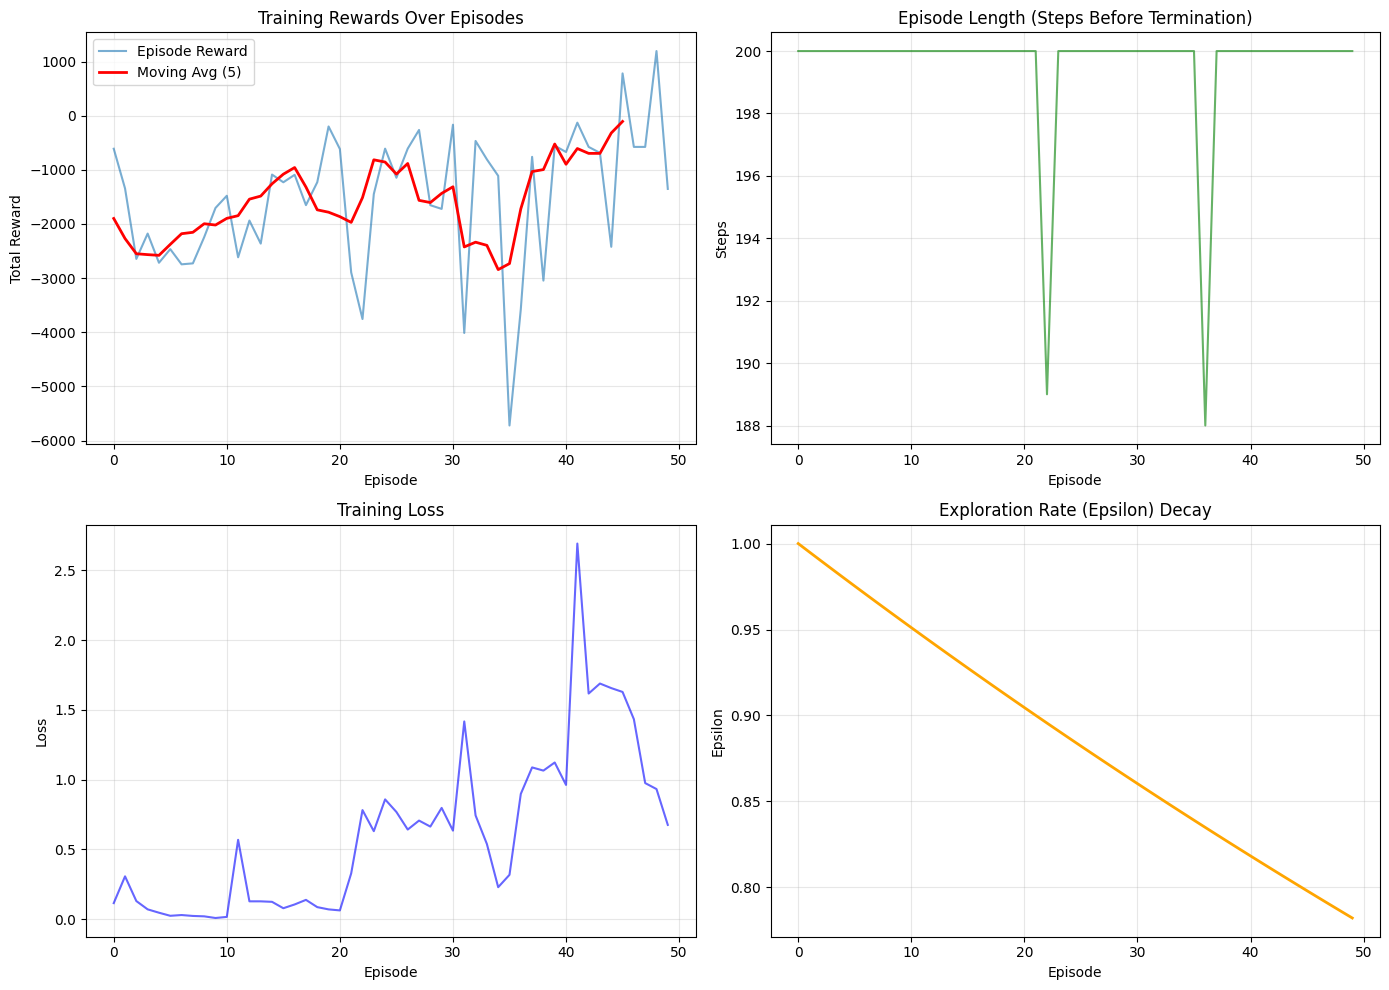

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Episode rewards
axes[0, 0].plot(rewards, alpha=0.6, label='Episode Reward')
axes[0, 0].plot(np.convolve(rewards, np.ones(5)/5, mode='valid'),
                'r-', linewidth=2, label='Moving Avg (5)')
axes[0, 0].set_xlabel('Episode')
axes[0, 0].set_ylabel('Total Reward')
axes[0, 0].set_title('Training Rewards Over Episodes')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Episode lengths
axes[0, 1].plot(lengths, 'g-', alpha=0.6)
axes[0, 1].set_xlabel('Episode')
axes[0, 1].set_ylabel('Steps')
axes[0, 1].set_title('Episode Length (Steps Before Termination)')
axes[0, 1].grid(True, alpha=0.3)

# Training loss
axes[1, 0].plot(losses, 'b-', alpha=0.6)
axes[1, 0].set_xlabel('Episode')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].set_title('Training Loss')
axes[1, 0].grid(True, alpha=0.3)

# Exploration rate
epsilon_values = [1.0 * (0.995 ** i) for i in range(len(rewards))]
axes[1, 1].plot(epsilon_values, 'orange', linewidth=2)
axes[1, 1].set_xlabel('Episode')
axes[1, 1].set_ylabel('Epsilon')
axes[1, 1].set_title('Exploration Rate (Epsilon) Decay')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Test Trained Agent

Evaluate the trained agent's performance on a test episode.

In [ ]:
def test_agent(agent, max_steps=200):
    """Test the trained agent and collect trajectory data."""
    env = SeparatorEnvironment(timeStep=50, levelSetpoint=0.3, pressureSetpoint=5.0)
    state = env.reset()

    # Data collection
    times = []
    levels = []
    pressures = []
    valve_openings = []
    actions_taken = []
    rewards_list = []

    total_reward = 0

    print("Testing trained agent...\n")

    for step in range(max_steps):
        # Get action from trained agent (no exploration)
        action = agent.act(state, training=False)

        # Record current state
        times.append(env.process.getTime())
        levels.append(env.level_tx.getMeasuredValue())
        pressures.append(env.pressure_tx.getMeasuredValue())
        valve_openings.append(env.feed_valve.getPercentValveOpening()) # Corrected from inlet_valve
        actions_taken.append(action)

        # Execute action
        next_state, reward, done = env.step(action)
        rewards_list.append(reward)
        total_reward += reward

        state = next_state

        if done:
            print(f"Episode terminated at step {step + 1}")
            break

    print(f"Total reward: {total_reward:.2f}")
    print(f"Average level error: {np.mean(np.abs(np.array(levels) - env.levelSetpoint)):.4f}")

    return times, levels, pressures, valve_openings, actions_taken, rewards_list

# Run test
test_times, test_levels, test_pressures, test_valves, test_actions, test_rewards = test_agent(trained_agent)

Testing trained agent...

Episode terminated at step 200
Total reward: -200.10
Average level error: 0.1000


## 8. Visualize Agent Performance

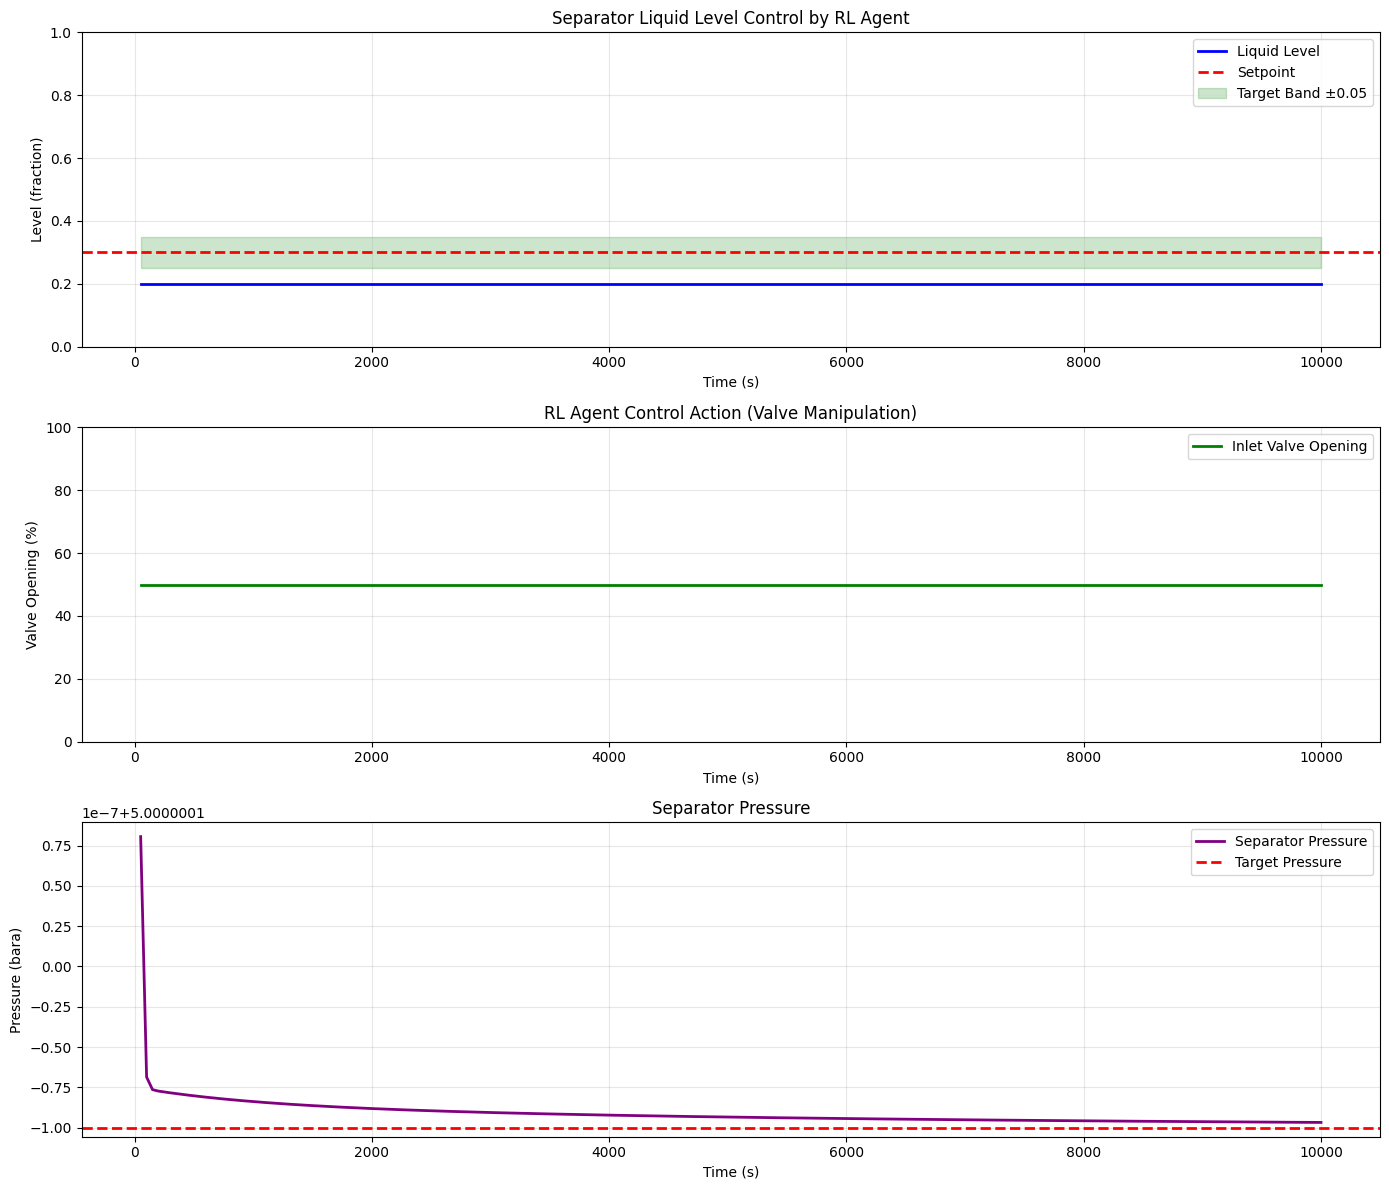

In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(14, 12))

# Liquid level
axes[0].plot(test_times, test_levels, 'b-', linewidth=2, label='Liquid Level')
axes[0].axhline(y=0.3, color='r', linestyle='--', linewidth=2, label='Setpoint')
axes[0].fill_between(test_times, 0.25, 0.35, alpha=0.2, color='green', label='Target Band ±0.05')
axes[0].set_xlabel('Time (s)')
axes[0].set_ylabel('Level (fraction)')
axes[0].set_title('Separator Liquid Level Control by RL Agent')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim([0, 1])

# Inlet valve opening
axes[1].plot(test_times, test_valves, 'g-', linewidth=2, label='Inlet Valve Opening')
axes[1].set_xlabel('Time (s)')
axes[1].set_ylabel('Valve Opening (%)')
axes[1].set_title('RL Agent Control Action (Valve Manipulation)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].set_ylim([0, 100])

# Pressure
axes[2].plot(test_times, test_pressures, 'purple', linewidth=2, label='Separator Pressure')
axes[2].axhline(y=5.0, color='r', linestyle='--', linewidth=2, label='Target Pressure')
axes[2].set_xlabel('Time (s)')
axes[2].set_ylabel('Pressure (bara)')
axes[2].set_title('Separator Pressure')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 9. Demonstrate Dynamic Setpoint Changes

Test the agent's ability to respond to changing operating conditions.

In [ ]:
def test_agent_with_setpoint_changes(agent, max_steps=400):
    """Test agent with dynamic setpoint changes during operation."""
    env = SeparatorEnvironment(timeStep=50, levelSetpoint=0.3, pressureSetpoint=5.0, flowRateSetpoint=150.0)
    state = env.reset()

    # Data collection
    times = []
    levels = []
    pressures = []
    flow_rates = []
    feed_valve_openings = []
    gas_valve_openings = []
    liquid_valve_openings = []
    level_setpoints = []
    pressure_setpoints = []
    flow_rate_setpoints = []
    actions_taken = []
    rewards_list = []

    total_reward = 0

    print("Testing agent with dynamic setpoint changes...\n")

    for step in range(max_steps):
        # Introduce setpoint changes at specific times
        if step == 100:
            print(f"Step {step}: Changing level setpoint from 0.3 to 0.5")
            env.set_level_setpoint(0.5)

        if step == 200:
            print(f"Step {step}: Changing pressure setpoint from 5.0 to 6.5 bara")
            env.set_pressure_setpoint(6.5)

        if step == 300:
            print(f"Step {step}: Changing feed flow rate from 150 to 200 kg/hr")
            env.set_flow_rate(200.0)

        # Get action from trained agent (no exploration)
        action = agent.act(state, training=False)

        # Record current state
        times.append(env.process.getTime())
        levels.append(env.level_tx.getMeasuredValue())
        pressures.append(env.pressure_tx.getMeasuredValue())
        flow_rates.append(env.well_stream.getFlowRate("kg/hr"))
        feed_valve_openings.append(env.feed_valve.getPercentValveOpening())
        gas_valve_openings.append(env.gas_valve.getPercentValveOpening())
        liquid_valve_openings.append(env.liquid_valve.getPercentValveOpening())
        level_setpoints.append(env.levelSetpoint)
        pressure_setpoints.append(env.pressureSetpoint)
        flow_rate_setpoints.append(env.flowRateSetpoint)
        actions_taken.append(action)

        # Execute action
        next_state, reward, done = env.step(action)
        rewards_list.append(reward)
        total_reward += reward

        state = next_state

        if done:
            print(f"Episode terminated at step {step + 1}")
            break

    print(f"\nTotal reward: {total_reward:.2f}")
    print(f"Final level: {levels[-1]:.3f} (setpoint: {level_setpoints[-1]:.3f})")
    print(f"Final pressure: {pressures[-1]:.2f} (setpoint: {pressure_setpoints[-1]:.2f})")
    print(f"Final flow rate: {flow_rates[-1]:.1f} (setpoint: {flow_rate_setpoints[-1]:.1f})")

    return {
        'times': times,
        'levels': levels,
        'pressures': pressures,
        'flow_rates': flow_rates,
        'feed_valves': feed_valve_openings,
        'gas_valves': gas_valve_openings,
        'liquid_valves': liquid_valve_openings,
        'level_setpoints': level_setpoints,
        'pressure_setpoints': pressure_setpoints,
        'flow_rate_setpoints': flow_rate_setpoints,
        'actions': actions_taken,
        'rewards': rewards_list
    }

# Run test with setpoint changes
results = test_agent_with_setpoint_changes(trained_agent, max_steps=400)

Testing agent with dynamic setpoint changes...

Step 100: Changing level setpoint from 0.3 to 0.5
Episode terminated at step 200

Total reward: -2365.23
Final level: 0.148 (setpoint: 0.500)
Final pressure: 9.81 (setpoint: 5.00)
Final flow rate: 30.1 (setpoint: 150.0)


## 10. Visualize Response to Setpoint Changes

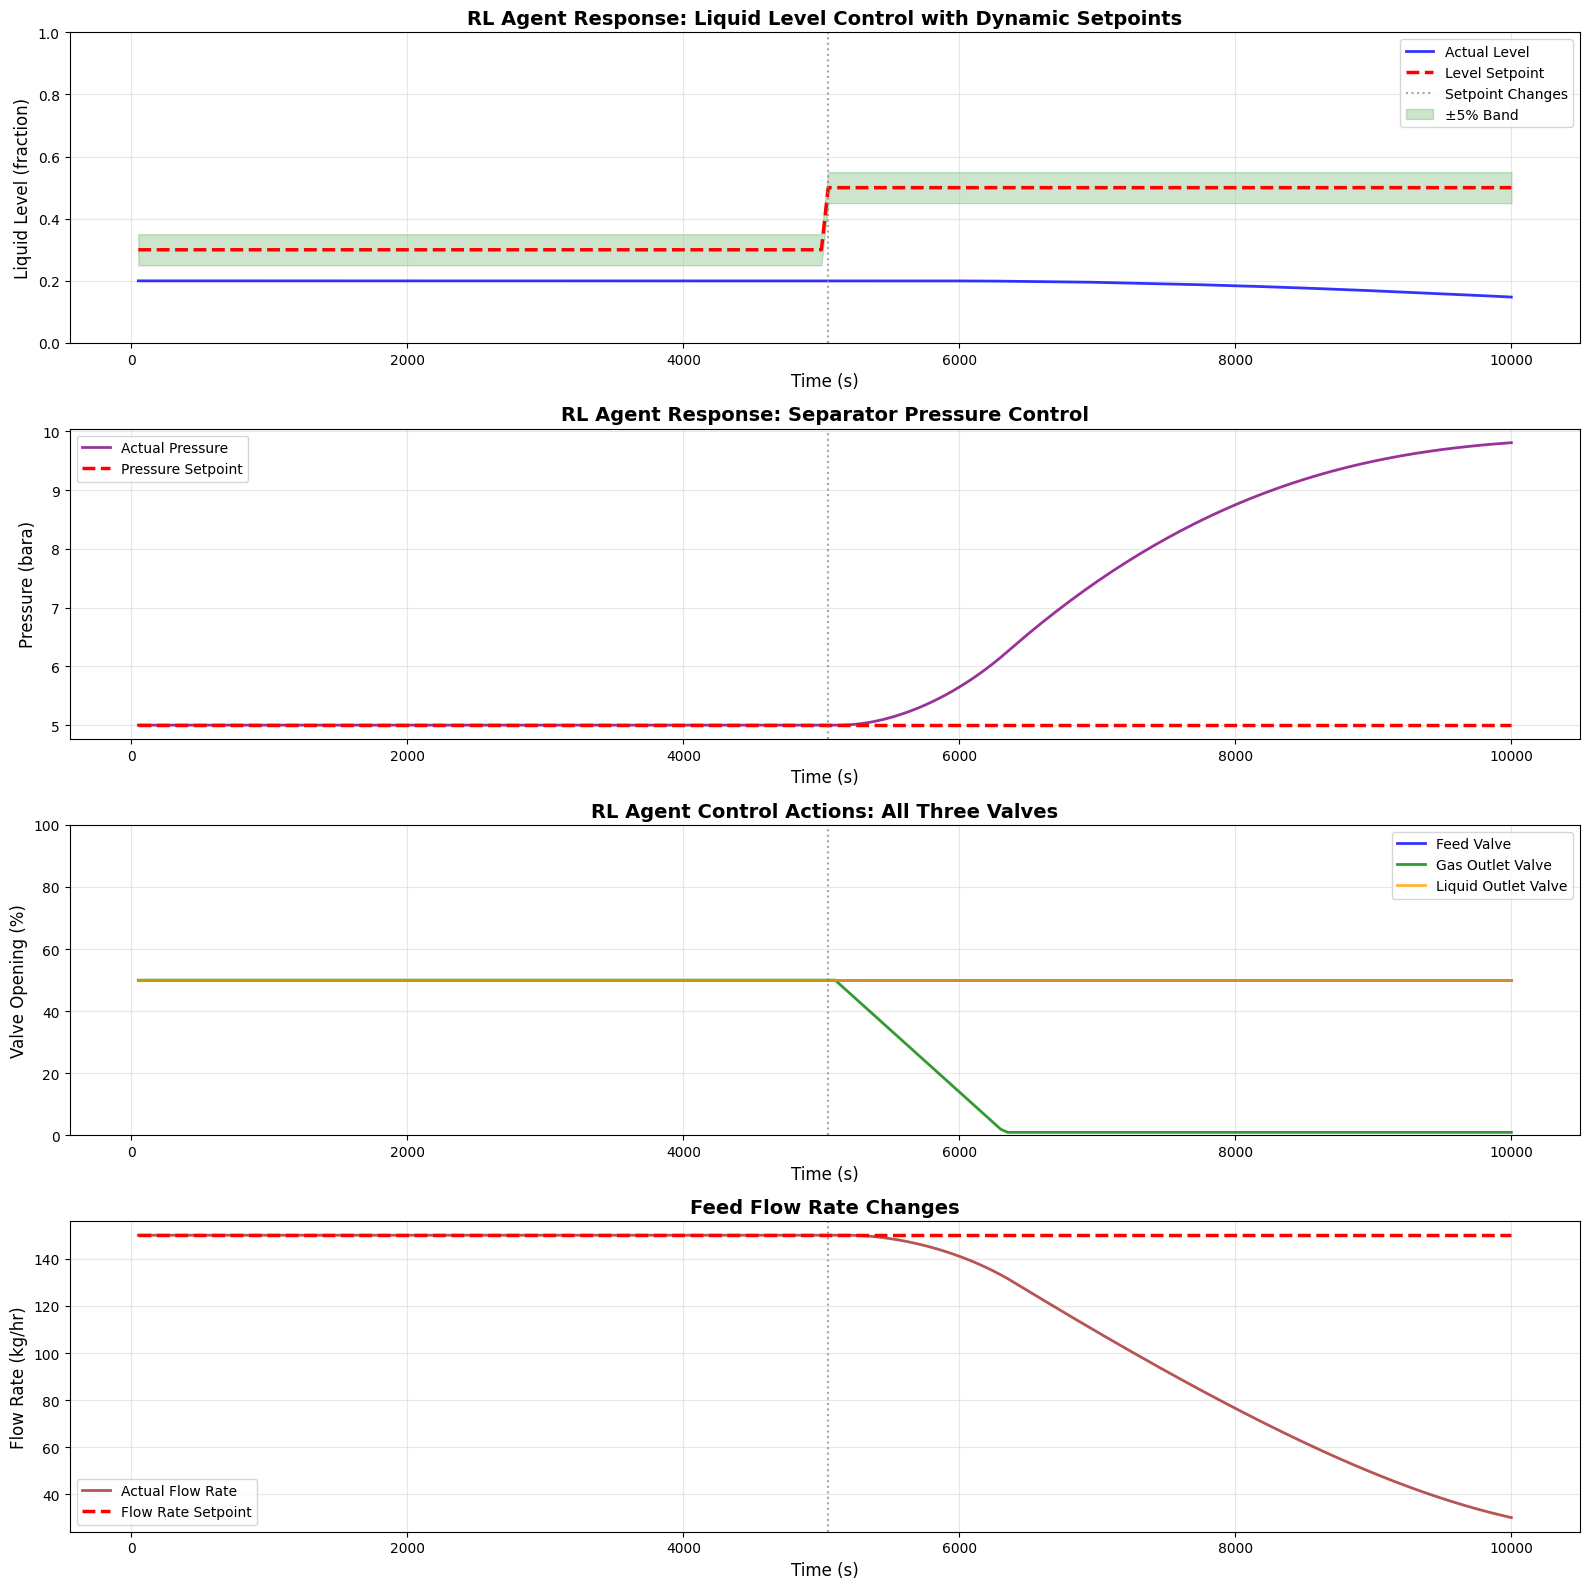


PERFORMANCE METRICS WITH DYNAMIC SETPOINTS
Average Level Error:     0.20789
Max Level Error:         0.35229
Average Pressure Error:  1.385 bara
Max Pressure Error:      4.807 bara

Setpoint Tracking:
  Level tracking (% within ±5%):    0.0%
  Pressure tracking (% within ±0.5): 58.5%


In [ ]:
fig, axes = plt.subplots(4, 1, figsize=(16, 16))

# 1. Liquid Level with Setpoint Changes
axes[0].plot(results['times'], results['levels'], 'b-', linewidth=2, label='Actual Level', alpha=0.8)
axes[0].plot(results['times'], results['level_setpoints'], 'r--', linewidth=2.5, label='Level Setpoint')
# Conditionally plot vertical lines if indices exist
if 100 < len(results['times']):
    axes[0].axvline(x=results['times'][100], color='gray', linestyle=':', alpha=0.7, label='Setpoint Changes')
if 200 < len(results['times']):
    axes[0].axvline(x=results['times'][200], color='gray', linestyle=':', alpha=0.7)
if 300 < len(results['times']):
    axes[0].axvline(x=results['times'][300], color='gray', linestyle=':', alpha=0.7)
axes[0].fill_between(results['times'],
                      np.array(results['level_setpoints']) - 0.05,
                      np.array(results['level_setpoints']) + 0.05,
                      alpha=0.2, color='green', label='±5% Band')
axes[0].set_xlabel('Time (s)', fontsize=12)
axes[0].set_ylabel('Liquid Level (fraction)', fontsize=12)
axes[0].set_title('RL Agent Response: Liquid Level Control with Dynamic Setpoints', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=10, loc='upper right')
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim([0, 1])

# 2. Separator Pressure with Setpoint Changes
axes[1].plot(results['times'], results['pressures'], 'purple', linewidth=2, label='Actual Pressure', alpha=0.8)
axes[1].plot(results['times'], results['pressure_setpoints'], 'r--', linewidth=2.5, label='Pressure Setpoint')
# Conditionally plot vertical lines if indices exist
if 100 < len(results['times']):
    axes[1].axvline(x=results['times'][100], color='gray', linestyle=':', alpha=0.7)
if 200 < len(results['times']):
    axes[1].axvline(x=results['times'][200], color='gray', linestyle=':', alpha=0.7)
if 300 < len(results['times']):
    axes[1].axvline(x=results['times'][300], color='gray', linestyle=':', alpha=0.7)
axes[1].set_xlabel('Time (s)', fontsize=12)
axes[1].set_ylabel('Pressure (bara)', fontsize=12)
axes[1].set_title('RL Agent Response: Separator Pressure Control', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

# 3. All Three Valve Positions
axes[2].plot(results['times'], results['feed_valves'], 'b-', linewidth=2, label='Feed Valve', alpha=0.8)
axes[2].plot(results['times'], results['gas_valves'], 'g-', linewidth=2, label='Gas Outlet Valve', alpha=0.8)
axes[2].plot(results['times'], results['liquid_valves'], 'orange', linewidth=2, label='Liquid Outlet Valve', alpha=0.8)
# Conditionally plot vertical lines if indices exist
if 100 < len(results['times']):
    axes[2].axvline(x=results['times'][100], color='gray', linestyle=':', alpha=0.7)
if 200 < len(results['times']):
    axes[2].axvline(x=results['times'][200], color='gray', linestyle=':', alpha=0.7)
if 300 < len(results['times']):
    axes[2].axvline(x=results['times'][300], color='gray', linestyle=':', alpha=0.7)
axes[2].set_xlabel('Time (s)', fontsize=12)
axes[2].set_ylabel('Valve Opening (%)', fontsize=12)
axes[2].set_title('RL Agent Control Actions: All Three Valves', fontsize=14, fontweight='bold')
axes[2].legend(fontsize=10)
axes[2].grid(True, alpha=0.3)
axes[2].set_ylim([0, 100])

# 4. Feed Flow Rate
axes[3].plot(results['times'], results['flow_rates'], 'brown', linewidth=2, label='Actual Flow Rate', alpha=0.8)
axes[3].plot(results['times'], results['flow_rate_setpoints'], 'r--', linewidth=2.5, label='Flow Rate Setpoint')
# Conditionally plot vertical lines if indices exist
if 100 < len(results['times']):
    axes[3].axvline(x=results['times'][100], color='gray', linestyle=':', alpha=0.7)
if 200 < len(results['times']):
    axes[3].axvline(x=results['times'][200], color='gray', linestyle=':', alpha=0.7)
if 300 < len(results['times']):
    axes[3].axvline(x=results['times'][300], color='gray', linestyle=':', alpha=0.7)
axes[3].set_xlabel('Time (s)', fontsize=12)
axes[3].set_ylabel('Flow Rate (kg/hr)', fontsize=12)
axes[3].set_title('Feed Flow Rate Changes', fontsize=14, fontweight='bold')
axes[3].legend(fontsize=10)
axes[3].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate performance metrics
level_errors = np.abs(np.array(results['levels']) - np.array(results['level_setpoints']))
pressure_errors = np.abs(np.array(results['pressures']) - np.array(results['pressure_setpoints']))

print("\n" + "="*70)
print("PERFORMANCE METRICS WITH DYNAMIC SETPOINTS")
print("="*70)
print(f"Average Level Error:     {np.mean(level_errors):.5f}")
print(f"Max Level Error:         {np.max(level_errors):.5f}")
print(f"Average Pressure Error:  {np.mean(pressure_errors):.3f} bara")
print(f"Max Pressure Error:      {np.max(pressure_errors):.3f} bara")
print(f"\nSetpoint Tracking:")
print(f"  Level tracking (% within ±5%):    {100 * np.sum(level_errors < 0.05) / len(level_errors):.1f}%")
print(f"  Pressure tracking (% within ±0.5): {100 * np.sum(pressure_errors < 0.5) / len(pressure_errors):.1f}%")
print("="*70)

## 10.5. Interactive Control Example

You can also change setpoints interactively during a running simulation:

In [ ]:
# Example: Run a custom scenario with your own setpoint changes
def custom_control_scenario(agent):
    """Run a custom control scenario with user-defined setpoint changes."""
    env = SeparatorEnvironment(timeStep=50, levelSetpoint=0.3, pressureSetpoint=5.0, flowRateSetpoint=150.0)
    state = env.reset()

    # Define your scenario here:
    scenarios = [
        {'step': 0, 'level_sp': 0.3, 'pressure_sp': 5.0, 'flow_rate': 150.0, 'description': 'Initial conditions'},
        {'step': 50, 'level_sp': 0.4, 'pressure_sp': None, 'flow_rate': None, 'description': 'Increase level to 40%'},
        {'step': 100, 'level_sp': None, 'pressure_sp': 6.0, 'flow_rate': None, 'description': 'Increase pressure to 6 bara'},
        {'step': 150, 'level_sp': None, 'pressure_sp': None, 'flow_rate': 200.0, 'description': 'Increase flow to 200 kg/hr'},
        {'step': 200, 'level_sp': 0.3, 'pressure_sp': 4.5, 'flow_rate': 150.0, 'description': 'Return to nominal conditions'},
    ]

    data = []
    print("Running custom control scenario:\n")

    for step in range(300):
        # Apply setpoint changes based on scenario
        for scenario in scenarios:
            if step == scenario['step']:
                print(f"Step {step}: {scenario['description']}")
                if scenario['level_sp'] is not None:
                    env.set_level_setpoint(scenario['level_sp'])
                if scenario['pressure_sp'] is not None:
                    env.set_pressure_setpoint(scenario['pressure_sp'])
                if scenario['flow_rate'] is not None:
                    env.set_flow_rate(scenario['flow_rate'])

        # Get action and execute
        action = agent.act(state, training=False)

        # Record data
        data.append({
            'time': env.process.getTime(),
            'level': env.level_tx.getMeasuredValue(),
            'pressure': env.pressure_tx.getMeasuredValue(),
            'flow_rate': env.well_stream.getFlowRate("kg/hr"),
            'feed_valve': env.feed_valve.getPercentValveOpening(),
            'gas_valve': env.gas_valve.getPercentValveOpening(),
            'liquid_valve': env.liquid_valve.getPercentValveOpening(),
            'level_sp': env.levelSetpoint,
            'pressure_sp': env.pressureSetpoint
        })

        next_state, reward, done = env.step(action)
        state = next_state

        if done:
            break

    print("\nScenario complete!")
    return data

# Uncomment to run:
# custom_data = custom_control_scenario(trained_agent)

## 11. Compare RL vs PID Control

Let's compare the RL agent's performance against traditional PID control.

In [ ]:
def run_pid_control(timeStep=50, totalTime=10000, levelSetpoint=0.3):
    """Run the same process with PID control for comparison."""
    # Process parameters
    flowRate = 150.0
    sepLength = 4.0
    sepDiameter = 1.0
    sepLiqLevel = 0.2
    inletValveOpening = 50.0
    inletValvePressure = 5.0
    gasValveOpening = 50.0
    gasValvePressure = 2.0
    liquidValveOpening = 50.0
    liquidValvePressure = 2.0

    # Setup fluid
    wellfluid = fluid("pr")
    wellfluid.addComponent("CO2", 1.5870)
    wellfluid.addComponent("methane", 52.51)
    wellfluid.addComponent("ethane", 6.24)
    wellfluid.addComponent("propane", 4.23)
    wellfluid.addComponent("i-butane", 0.855)
    wellfluid.addComponent("n-butane", 2.213)
    wellfluid.addComponent("i-pentane", 1.124)
    wellfluid.addComponent("n-pentane", 1.271)
    wellfluid.addComponent("n-hexane", 2.289)
    wellfluid.addTBPfraction("C7+_cut1", 0.8501, 108.47 / 1000.0, 0.7411)
    wellfluid.addTBPfraction("C7+_cut2", 1.2802, 120.4 / 1000.0, 0.755)
    wellfluid.addTBPfraction("C7+_cut3", 1.6603, 133.64 / 1000.0, 0.7695)
    wellfluid.addTBPfraction("C7+_cut4", 6.5311, 164.70 / 1000.0, 0.799)
    wellfluid.addTBPfraction("C7+_cut5", 6.3311, 215.94 / 1000.0, 0.8387)
    wellfluid.addTBPfraction("C7+_cut6", 4.9618, 273.34 / 1000.0, 0.8754)
    wellfluid.addTBPfraction("C7+_cut7", 2.9105, 334.92 / 1000.0, 0.90731)
    wellfluid.addTBPfraction("C7+_cut8", 3.0505, 412.79 / 1000.0, 0.9575)
    wellfluid.setPressure(10)
    wellfluid.setTemperature(300)
    wellfluid.setMixingRule("classic")

    # Build process
    wellStream = ns.process.equipment.stream.Stream("well stream", wellfluid)
    wellStream.setFlowRate(flowRate, "kg/hr")

    lcv00 = ns.process.equipment.valve.ThrottlingValve("LCV-00", wellStream)
    lcv00.setPercentValveOpening(inletValveOpening)
    lcv00.setOutletPressure(inletValvePressure)
    lcv00.setCalculateSteadyState(False)
    lcv00.setMinimumValveOpening(0.01)

    v001 = ns.process.equipment.separator.Separator("V-001", lcv00.getOutletStream())
    v001.setCalculateSteadyState(False)
    v001.setSeparatorLength(sepLength)
    v001.setInternalDiameter(sepDiameter)
    v001.setLiquidLevel(sepLiqLevel)

    lcv001 = ns.process.equipment.valve.ThrottlingValve("LCV-001", v001.getLiquidOutStream())
    lcv001.setPercentValveOpening(liquidValveOpening)
    lcv001.setOutletPressure(liquidValvePressure)
    lcv001.setCalculateSteadyState(False)

    pcv001 = ns.process.equipment.valve.ThrottlingValve("PCV-001", v001.getGasOutStream())
    pcv001.setPercentValveOpening(gasValveOpening)
    pcv001.setOutletPressure(gasValvePressure)
    pcv001.setCalculateSteadyState(False)

    # PID controller setup
    lt01 = ns.process.measurementdevice.LevelTransmitter(v001)
    lt01.setMaximumValue(0.99)
    lt01.setMinimumValue(0.01)

    lc01 = ns.process.controllerdevice.ControllerDeviceBaseClass()
    lc01.setTransmitter(lt01)
    lc01.setReverseActing(True)
    lc01.setControllerSetPoint(levelSetpoint)
    lc01.setControllerParameters(25.80, 400.1, 0.0)

    pt01 = ns.process.measurementdevice.PressureTransmitter(v001.getGasOutStream())
    pt01.setMaximumValue(10.0)
    pt01.setMinimumValue(0.01)

    pc01 = ns.process.controllerdevice.ControllerDeviceBaseClass()
    pc01.setTransmitter(pt01)
    pc01.setReverseActing(False)
    pc01.setControllerSetPoint(inletValvePressure)
    pc01.setControllerParameters(1.0, 2000.0, 0.0)

    oilProcess = ns.process.processmodel.ProcessSystem("oil process")
    oilProcess.add(wellStream)
    oilProcess.add(lcv00)
    oilProcess.add(v001)
    oilProcess.add(lcv001)
    oilProcess.add(pcv001)
    oilProcess.add(lt01)
    oilProcess.add(pt01)
    lcv00.setController(lc01)
    pcv001.setController(pc01)

    oilProcess.run()
    oilProcess.setTimeStep(timeStep)
    oilProcess.runTransient()

    # Collect data
    times = []
    levels = []
    valves = []
    pressures = []

    for i in range(int(totalTime / timeStep)):
        times.append(oilProcess.getTime())
        levels.append(oilProcess.getUnit("V-001").getLiquidLevel())
        valves.append(lcv00.getPercentValveOpening())
        pressures.append(pt01.getMeasuredValue())
        oilProcess.runTransient()

    return times, levels, valves, pressures

print("Running PID control simulation...")
pid_times, pid_levels, pid_valves, pid_pressures = run_pid_control(timeStep=50, totalTime=10000)
print("PID simulation complete!")

Running PID control simulation...
PID simulation complete!


## 12. Performance Comparison Plot

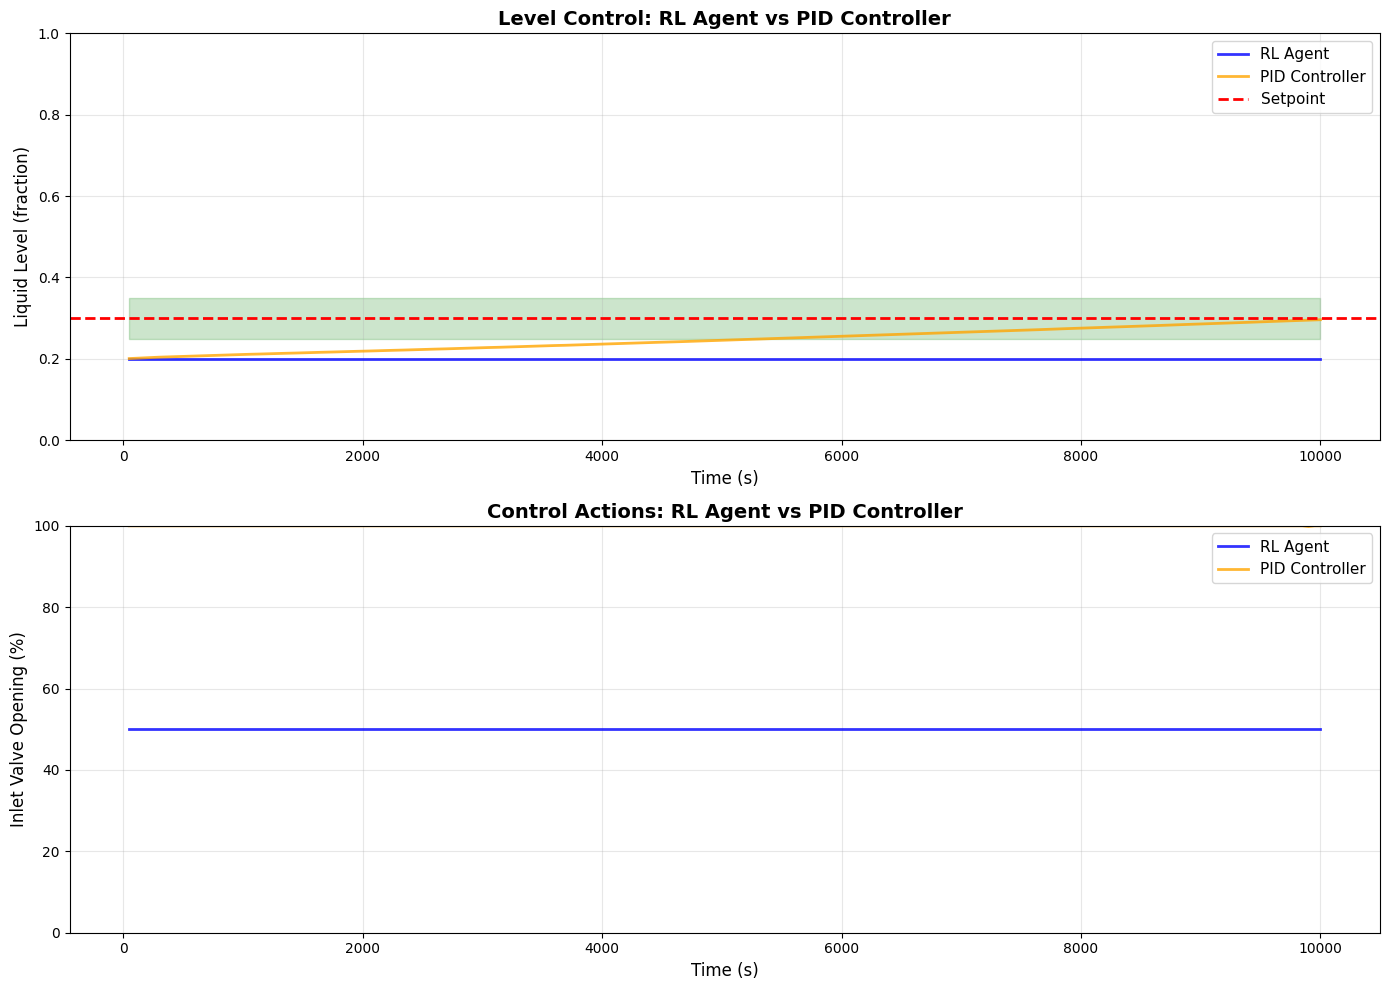


PERFORMANCE COMPARISON
Average Level Error:
  RL Agent:       0.10005
  PID Controller: 0.05289

Valve Action Smoothness (lower = smoother):
  RL Agent:       0.0000
  PID Controller: 0.0178


In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Level comparison
axes[0].plot(test_times, test_levels, 'b-', linewidth=2, label='RL Agent', alpha=0.8)
axes[0].plot(pid_times, pid_levels, 'orange', linewidth=2, label='PID Controller', alpha=0.8)
axes[0].axhline(y=0.3, color='r', linestyle='--', linewidth=2, label='Setpoint')
axes[0].fill_between(test_times[:len(pid_times)], 0.25, 0.35, alpha=0.2, color='green')
axes[0].set_xlabel('Time (s)', fontsize=12)
axes[0].set_ylabel('Liquid Level (fraction)', fontsize=12)
axes[0].set_title('Level Control: RL Agent vs PID Controller', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim([0, 1])

# Valve opening comparison
axes[1].plot(test_times, test_valves, 'b-', linewidth=2, label='RL Agent', alpha=0.8)
axes[1].plot(pid_times, pid_valves, 'orange', linewidth=2, label='PID Controller', alpha=0.8)
axes[1].set_xlabel('Time (s)', fontsize=12)
axes[1].set_ylabel('Inlet Valve Opening (%)', fontsize=12)
axes[1].set_title('Control Actions: RL Agent vs PID Controller', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)
axes[1].set_ylim([0, 100])

plt.tight_layout()
plt.show()

# Calculate performance metrics
rl_level_error = np.mean(np.abs(np.array(test_levels) - 0.3))
pid_level_error = np.mean(np.abs(np.array(pid_levels) - 0.3))
rl_valve_variation = np.std(np.diff(test_valves))
pid_valve_variation = np.std(np.diff(pid_valves))

print("\n" + "="*60)
print("PERFORMANCE COMPARISON")
print("="*60)
print(f"Average Level Error:")
print(f"  RL Agent:       {rl_level_error:.5f}")
print(f"  PID Controller: {pid_level_error:.5f}")
print(f"\nValve Action Smoothness (lower = smoother):")
print(f"  RL Agent:       {rl_valve_variation:.4f}")
print(f"  PID Controller: {pid_valve_variation:.4f}")
print("="*60)

## 13. Key Insights and Next Steps

### What We Demonstrated:
1. **Multi-Valve Control**: RL agent controls three valves simultaneously (feed, gas outlet, liquid outlet)
2. **Dynamic Setpoints**: System can change level, pressure, and flow rate setpoints during operation
3. **Custom RL Environment**: Wrapped NeqSim process simulation with state space including all process variables
4. **DQN Agent**: Implemented deep Q-learning with experience replay for complex control tasks
5. **Adaptive Control**: Agent learns to respond to changing operating conditions

### Key Features:
- **State Space (8 dimensions)**:
  - Liquid level, separator pressure, feed flow rate
  - Level error, pressure error
  - Three valve positions (feed, gas, liquid)
  
- **Action Space (9 discrete actions)**:
  - Actions 0-2: Feed valve (decrease/hold/increase)
  - Actions 3-5: Gas outlet valve (decrease/hold/increase)
  - Actions 6-8: Liquid outlet valve (decrease/hold/increase)

- **Dynamic Operation**:
  - `env.set_level_setpoint(value)` - Change level target (0.1-0.9)
  - `env.set_pressure_setpoint(value)` - Change pressure target (1-10 bara)
  - `env.set_flow_rate(value)` - Change feed flow (50-300 kg/hr)

### Advantages of RL Control:
- **Multi-objective optimization**: Simultaneously controls level and pressure with multiple valves
- **Learns from experience**: Discovers optimal valve coordination strategies
- **Handles nonlinearities**: No need for explicit process models
- **Adapts to disturbances**: Responds to changing setpoints and operating conditions
- **Coordinated actions**: Learns how all three valves interact

### Future Enhancements:
1. **Advanced algorithms**: Try PPO, A3C, or SAC for continuous action spaces
2. **Continuous actions**: Direct valve position control instead of discrete steps
3. **Model-based RL**: Learn process dynamics to improve sample efficiency
4. **Multi-agent systems**: Coordinate multiple separators or process units
5. **Safety constraints**: Hard limits on pressure/level for operational safety
6. **Transfer learning**: Train on one configuration, adapt to others
7. **Real-time optimization**: Incorporate economic objectives (energy, throughput)

### Hyperparameter Tuning:
Try adjusting these parameters for better performance:
- **Learning rate**: 0.001 (current) → try 0.0001 or 0.01
- **Discount factor γ**: 0.95 → try 0.99 for longer-term planning
- **Network architecture**: Add more layers or neurons (current: 64-64-32)
- **Reward function**: Adjust penalties for level/pressure errors
- **Exploration decay**: Modify epsilon decay rate for exploration/exploitation balance
- **Valve step size**: 2.0% (current) → try 1.0% for finer control or 5.0% for faster response

## 14. Save Trained Model (Optional)

In [ ]:
# Save the trained model
model_path = "separator_dqn_model.h5"
trained_agent.save(model_path)
print(f"Model saved to {model_path}")

# To load later:
# agent = DQNAgent(state_size=4, action_size=3)
# agent.load(model_path)